In [3]:
import os
import torch
import csv
import random
import pandas as pd
import numpy as np
import torch.nn as nn
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from numpy import unique
import torch.optim as optim
from google.colab import drive
from warnings import filterwarnings


# Function

In [9]:
train_dataset = pd.read_csv('/content/drive/MyDrive/all_data.csv')
test_dataset = pd.read_csv('/content/drive/MyDrive/wearable-data_100_f.csv')

In [ ]:
X_train = train_dataset.drop(columns=['label'])
y_train = train_dataset['label']

In [15]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))

In [16]:
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train.values)

In [ ]:
X_test = test_dataset.drop(columns=['label'])
y_test = test_dataset['label']

In [ ]:
X_train_meta, y_train_meta, X_test_meta, y_test_meta = train_test_split(
    X_test, y_test, test_size=0.20, random_state=10, stratify=y_test, shuffle=True
)

In [17]:
X_train_meta_tensor = torch.tensor(X_train_meta, dtype=torch.float32)
y_train_meta_tensor = torch.tensor(y_train_meta.values, dtype=torch.float32)

In [18]:
X_test_meta_tensor = torch.tensor(X_test_meta,dtype=torch.float32)
y_test_meta_tensor = torch.tensor(y_test_meta.values,dtype=torch.float32)

### MobileNETv2

In [22]:
import torch
import torch.nn as nn

class ConvNormActivation(torch.nn.Sequential):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size = 3,
        stride = 1,
        padding = None,
        groups = 1,
        norm_layer = nn.BatchNorm1d,
        activation_layer = torch.nn.ReLU,
        dilation = 1,
        inplace = True,
        bias = None,
        conv_layer = torch.nn.Conv1d,
    ):

        if padding is None:
          #  if isinstance(kernel_size, int) and isinstance(dilation, int):
          #       padding = (kernel_size - 1) // 2 * dilation
          #   else:
          #       _conv_dim = len(kernel_size) if isinstance(kernel_size, Sequence) else len(dilation)
          #       kernel_size = _make_ntuple(kernel_size, _conv_dim)
          #       dilation = _make_ntuple(dilation, _conv_dim)
          #       padding = tuple((kernel_size[i] - 1) // 2 * dilation[i] for i in range(_conv_dim))
          padding = (kernel_size - 1) // 2 * dilation
        if bias is None:
            bias = norm_layer is None

        layers = [
            conv_layer(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                dilation=dilation,
                groups=groups,
                bias=bias,
            )
        ]

        if norm_layer is not None:
            layers.append(norm_layer(out_channels))

        if activation_layer is not None:
            params = {} if inplace is None else {"inplace": inplace}
            layers.append(activation_layer(**params))
        super().__init__(*layers)
        #_log_api_usage_once(self)
        self.out_channels = out_channels

        # if self.__class__ == ConvNormActivation:
        #     warnings.warn(
        #         "Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead."
        #     )


class Conv1dNormActivation(ConvNormActivation):
    """
    Configurable block used for Convolution2d-Normalization-Activation blocks.

    Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the Convolution-Normalization-Activation block
        kernel_size: (int, optional): Size of the convolving kernel. Default: 3
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int, tuple or str, optional): Padding added to all four sides of the input. Default: None, in which case it will be calculated as ``padding = (kernel_size - 1) // 2 * dilation``
        groups (int, optional): Number of blocked connections from input channels to output channels. Default: 1
        norm_layer (Callable[..., torch.nn.Module], optional): Norm layer that will be stacked on top of the convolution layer. If ``None`` this layer won't be used. Default: ``torch.nn.BatchNorm2d``
        activation_layer (Callable[..., torch.nn.Module], optional): Activation function which will be stacked on top of the normalization layer (if not None), otherwise on top of the conv layer. If ``None`` this layer won't be used. Default: ``torch.nn.ReLU``
        dilation (int): Spacing between kernel elements. Default: 1
        inplace (bool): Parameter for the activation layer, which can optionally do the operation in-place. Default ``True``
        bias (bool, optional): Whether to use bias in the convolution layer. By default, biases are included if ``norm_layer is None``.

    """

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size = 3,
        stride = 1,
        padding = None,
        groups = 1,
        norm_layer = torch.nn.BatchNorm1d,
        activation_layer = torch.nn.ReLU,
        dilation = 1,
        inplace = True,
        bias = None,
    ):

        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups,
            norm_layer,
            activation_layer,
            dilation,
            inplace,
            bias,
            torch.nn.Conv1d,
        )


class InvertedResidual(nn.Module):

    def __init__(
        self,
        inp,
        oup,
        stride,
        expand_ratio,
        norm_layer = None
    ):

        super().__init__()
        self.stride = stride
        # if stride not in [1, 2]:
        #     raise ValueError(f"stride should be 1 or 2 instead of {stride}")

        if norm_layer is None:
            norm_layer = nn.BatchNorm1d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(
                Conv1dNormActivation(inp,
                                     hidden_dim,
                                     kernel_size = 1,
                                     norm_layer=norm_layer,
                                     activation_layer=nn.ReLU6)
            )
        layers.extend(
            [
                # dw
                Conv1dNormActivation(
                    hidden_dim,
                    hidden_dim,
                    stride=stride,
                    groups=hidden_dim,
                    norm_layer=norm_layer,
                    activation_layer=nn.ReLU6,
                ),
                # pw-linear
                nn.Conv1d(hidden_dim, oup, 1, 1, 0, bias=False),
                norm_layer(oup),
            ]
        )
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup
        self._is_cn = stride > 1

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class MobileNetV2(nn.Module):
    def __init__(
        self,
        num_classes = 128,
        input_length = 1000,
        width_mult = 1.0,
        inverted_residual_setting = None,
        round_nearest = 8,
        block = None,
        norm_layer = None,
        dropout = 0.2,
    ):
        """
        MobileNet V2 main class

        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
            norm_layer: Module specifying the normalization layer to use
            dropout (float): The droupout probability

        """
        super().__init__()
        #_log_api_usage_once(self)

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm1d

        image_channel = 1
        input_channel = 32
        last_channel = 128
        self.input_length = input_length

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 128, 3, 1]
                # [6, 160, 3, 2],
                # [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError(
                f"inverted_residual_setting should be non-empty or a 4-element list, got {inverted_residual_setting}"
            )

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features = [
            Conv1dNormActivation(image_channel,
                                 input_channel,
                                 stride= 2,
                                 norm_layer=norm_layer,
                                 activation_layer=nn.ReLU6)
        ]

        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel,
                                      output_channel,
                                      stride,
                                      expand_ratio=t,
                                      norm_layer=norm_layer))
                input_channel = output_channel

        # building last several layers
        features.append(
            Conv1dNormActivation(
                input_channel,
                self.last_channel,
                kernel_size= 1,
                norm_layer=norm_layer,
                activation_layer=nn.ReLU6
            )
        )
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm1d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x):
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1
        x = nn.functional.adaptive_avg_pool1d(x, 1)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def forward(self, x):
        x = torch.reshape(x, (-1, 1, self.input_length))
        return self._forward_impl(x)


model_mobilenet = MobileNetV2()

In [25]:
def df_class(X, Y, n):
    class_list = []
    for i in range(n):
        class_mask = Y == i
        df_i_label = X[class_mask]
        class_list.append(df_i_label)
    return class_list

In [38]:
train_class = df_class(X_train_tensor, y_train_tensor, 4)

train_class_indices = [0, 1, 2,3]
train_patches_class = [train_class[i] for i in train_class_indices]
train_class_labels = [0, 1, 2,3]

In [39]:
test_class_1= df_class(X_train_meta_tensor,y_train_meta_tensor,2)
test_class_2 = df_class(X_test_meta_tensor,y_test_meta_tensor,2)

In [40]:
test_class_indices = [0,1]
test_class_labels = [0,1]

test_patches_class_1 = [test_class_1[i] for i in test_class_indices]
test_patches_class_2 = [test_class_2[i] for i in test_class_indices]

In [41]:
def calc_euclidean_dists(x, y):
    n = x.size(0)
    m = y.size(0)

    x = x.unsqueeze(1).expand(n, m, -1)
    y = y.unsqueeze(0).expand(n, m, -1)

    return torch.mean(torch.pow(x - y, 2), dim=2)

def calc_std_predictions(mc_predictions):
    mc_predictions_tensor = torch.stack(mc_predictions, dim=0)
    std_predictions = torch.std(mc_predictions_tensor, dim=0)

    return std_predictions

def calc_mean_accuracy(predictions, y):

    accuracy = torch.mean((torch.argmax(predictions, dim=-1) == torch.argmax(y, dim=-1)).float())

    return accuracy

### Protomodel

In [42]:
mc_loss_weight = 0.5
n_times = 10
class Prototypical(nn.Module):
    def __init__(self, model_mobilenet, d):
        super(Prototypical, self).__init__()
        self.d = d
        self.encoder = model_mobilenet

    def forward(self, support, query, support_labels, query_labels, K, C, N, n_times, training):
        n_class = C
        n_support = K
        n_query = N
        tC = 2
        n_times = 10

        if training == True :
            loss = 0
            mc_predictions = []
            for i in range(n_times) :                                               # n_times passing every query sample for calculating variance

                y = torch.zeros((int(C*N),C))
                for i in range(int(C*N)):
                    x = (support_labels == query_labels[i]).nonzero(as_tuple=True)[0]                        # creation of 1-hot for true labels
                    y[i][x] = 1.
                cat = torch.cat([support,query], axis=0)
                z = self.encoder(cat)
                #print(z)
                z_prototypes = z[:n_class * n_support].view(n_class, n_support, z.shape[-1])
                z_prototypes = torch.mean(z_prototypes, dim=1)
                z_query = z[n_class * n_support:]
                dists = calc_euclidean_dists(z_query, z_prototypes)

                log_p_y = torch.nn.functional.log_softmax(-dists, dim=-1)
                #print(log_p_y)
                # y_tensor = torch.from_numpy(y)
                # loss1 = -torch.mean(torch.sum(y_tensor * log_p_y, dim=-1))
                y = y.cuda()
                loss1  = -torch.mean(torch.sum(y * log_p_y, dim=-1))
                loss += loss1
                predictions = torch.nn.functional.softmax(-dists, dim=-1)
                mc_predictions.append(predictions)

            mc_predictions = torch.stack(mc_predictions, axis =0)
            std_predictions = torch.std(mc_predictions, axis = 0)
            mean_predictions = torch.mean(mc_predictions, axis =0)
            std = torch.sum(torch.sum(std_predictions * y,axis=1))

            # Calculate the loss and accuracy
            loss += mc_loss_weight*std
            #print(loss)
            mean_accuracy = calc_mean_accuracy(mean_predictions,y)

            return loss, mean_accuracy, mean_predictions

        if training == False:
          loss = 0
          mc_predictions = []
          for i in range(n_times):
            y = torch.zeros((int(C*N), C))
            for i in range(int(C*N)):
              #x = support_labels.index(query_labels[i])
              x = (support_labels == query_labels[i]).nonzero(as_tuple=True)[0]
              y[i][x] = 1.

            cat = torch.cat([support, query], dim=0)
            z = self.encoder(cat)
            z_prototypes = z[:n_class * n_support].view(n_class, n_support, z.shape[-1])
            z_prototypes = torch.mean(z_prototypes, dim=1)
            z_query = z[n_class * n_support:]
            #print('z_prototypes 0',z_prototypes[0])
            #print('z_prototypes 1',z_prototypes[1])
            dists = calc_euclidean_dists(z_query, z_prototypes)
           # print('dist 0',dists[0])
           # print('dist 1',dists[1])
            log_p_y = torch.nn.functional.log_softmax(-dists, dim=-1)
            # print('log_p_y 0',log_p_y[0])
            # print('log_p_y 1',log_p_y[1])
            #y = y.cuda()
            loss1 = -torch.mean(torch.sum(log_p_y * y, dim=-1))
            loss += loss1
            predictions = torch.nn.functional.softmax(-dists, dim=-1)
            # print('predictions 0',predictions[0])
            # print('predictions 1',predictions[1])
            mc_predictions.append(predictions)
            #print('mc_predictions ',mc_predictions)

          classwise_mean_acc = []
          mc_predictions = torch.stack(mc_predictions, axis =0)
          mean_predictions = torch.mean(mc_predictions, axis=0)


          mean_eq = torch.tensor(torch.argmax(mean_predictions, dim=-1).int() == torch.argmax(y, dim=-1).int(), dtype=torch.float32)
          mean_accuracy = torch.mean(mean_eq)
          mean_pred_index = torch.argmax(mean_predictions, dim=1)
    # Mean class-wise accuracies
          mean_correct_class = [[] for _ in range(tC)]
          mean_correct_pred = [[] for _ in range(tC)]
          classwise_mean_acc = [[] for _ in range(tC)]

          for i in range(int(C * N)):
              #x = support_labels.index(query_labels[i])
              x = (support_labels == query_labels[i]).nonzero(as_tuple=True)[0]
              mean_correct_class[x].append('4')

              if mean_pred_index[i] == x:
                  mean_correct_pred[x].append('4')

          for i in range(tC):
              z = len(mean_correct_pred[i]) / len(mean_correct_class[i])
              classwise_mean_acc[i].append(z)

          # Standard deviation calculation
          # std = 0
          # for i in range(int(C * N)):
          #    # x = support_labels.index(query_labels[i])
          #     x = (support_labels == query_labels[i]).nonzero(as_tuple=True)[0]
          #     p_i = torch.stack([p[i, :] for p in mc_predictions])
          #     std_i = torch.std(p_i, dim=0)
          #     std_i_true = std_i[x]
          #     std += std_i_true

          # loss += mc_loss_weight * std

          # y = torch.zeros((int(C * N), C))
          # for i in range(int(C * N)):
          #     x = (support_labels == query_labels[i]).nonzero(as_tuple=True)[0]
          #     #x = support_labels.index(query_labels[i])
          #     y[i][x] = 1.

        return  mc_predictions, mean_accuracy, y
          #return  mc_predictions


    def save(self, model_path):
      torch.save(self.encoder.state_dict(), model_path)

    def load(self, model_path):
      self.encoder.load_state_dict(torch.load(model_path))

In [43]:
ProtoModel = Prototypical(model_mobilenet, 1000)
ProtoModel.cuda()
n_times = 10
optimizer = optim.Adam(ProtoModel.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Train Base learner

In [44]:
def train_episode(df_list, K, C, N, class_labels):
    selected_classes = np.random.choice(class_labels, C, replace=False)
    support_list = []
    query_list = []
    query_labels = []
    support_labels = torch.tensor(selected_classes)

    for x in selected_classes:
        df_indices = np.random.choice(len(df_list[x - 1]), K, replace=False)
        support_ = df_list[x - 1][df_indices, :]
        qran_indices = np.random.choice(len(df_list[x - 1]), N, replace=False)
        query_ = df_list[x - 1][qran_indices, :]

        for i in range(N):
            query_labels.append(x)
        query_list.extend(query_)
        support_list.extend(support_)

    temp1 = list(zip(query_list, query_labels))
    random.shuffle(temp1)
    query_list, query_labels = zip(*temp1)

    query_list = torch.reshape(torch.cat(query_list), (C * N, 1000))
    support_list = torch.reshape(torch.cat(support_list), (C * K, 1000))
    support_list = support_list.unsqueeze(-1)
    query_list = query_list.unsqueeze(-1)
    query_labels = torch.tensor(query_labels)
    # print('support shape:',support_list.shape )
    # print('query shape:',query_list.shape )
    return query_list, support_list, query_labels, support_labels

### with GPU

In [45]:
def train_step(support, query, support_labels, query_labels, K, C, N, training=True):
    #support = torch.cat(support, 0)
    #query = torch.cat(query,0)
    support = support.cuda().float()
    query = query.cuda().float()
    support_labels = support_labels.cuda().float()
    query_labels = query_labels.cuda().float()
    loss, mean_accuracy, mean_predictions = ProtoModel(support, query, support_labels, query_labels, K, C, N, n_times, training=True)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), mean_accuracy.item(), mean_predictions

### with CPU

In [29]:
def train_step(support, query, support_labels, query_labels, K, C, N, training=True):
    loss, mean_accuracy, mean_predictions = ProtoModel(support, query, support_labels, query_labels, K, C, N, n_times, training=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), mean_accuracy.item(), mean_predictions

In [46]:
checkpoint_dir = '/content/drive/MyDrive/Model-checkpoints/train/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

### train loop

In [47]:
K1 = 10      #support
C = 4      #Class
N = 15      # query
n_episodes = 100

for epoch in range(100):
    train_loss = 0.0
    train_acc = 0.0
    for epi in range(n_episodes):
        tquery_list, tsupport_list, query_labels, support_labels = train_episode(train_class, K1, C, N, train_class_labels)

        train_loss_temp , temp_acc , c = train_step(tsupport_list, tquery_list, support_labels, query_labels, K1, C, N)
        train_loss += train_loss_temp
        train_acc += temp_acc
    # Print the training loss and accuracy
    print('Epoch {}, Train Loss: {:.2f}, Train Accuracy: {:.2f}'.format(epoch + 1, train_loss/n_episodes, train_acc/n_episodes * 100))

    # if (epoch + 1) % 2 == 0:
    #  torch.save(ProtoModel.state_dict(), f"{checkpoint_prefix}_epoch_{epoch + 1}.pth")

Epoch 1, Train Loss: 10.99, Train Accuracy: 36.04
Epoch 2, Train Loss: 10.55, Train Accuracy: 45.27
Epoch 3, Train Loss: 9.05, Train Accuracy: 57.00
Epoch 4, Train Loss: 8.50, Train Accuracy: 61.20
Epoch 5, Train Loss: 8.16, Train Accuracy: 64.33
Epoch 6, Train Loss: 7.93, Train Accuracy: 65.36
Epoch 7, Train Loss: 7.73, Train Accuracy: 67.02
Epoch 8, Train Loss: 7.78, Train Accuracy: 66.78
Epoch 9, Train Loss: 7.63, Train Accuracy: 66.87
Epoch 10, Train Loss: 7.38, Train Accuracy: 69.16
Epoch 11, Train Loss: 7.05, Train Accuracy: 70.84
Epoch 12, Train Loss: 7.03, Train Accuracy: 71.07
Epoch 13, Train Loss: 6.96, Train Accuracy: 70.71
Epoch 14, Train Loss: 6.89, Train Accuracy: 71.20
Epoch 15, Train Loss: 6.97, Train Accuracy: 71.62
Epoch 16, Train Loss: 6.77, Train Accuracy: 73.22
Epoch 17, Train Loss: 6.70, Train Accuracy: 73.69
Epoch 18, Train Loss: 6.66, Train Accuracy: 74.27
Epoch 19, Train Loss: 6.50, Train Accuracy: 74.38
Epoch 20, Train Loss: 6.45, Train Accuracy: 73.67
Epoch 2

In [48]:
torch.save(ProtoModel.state_dict(), "/content/drive/MyDrive/all_train_weights.pth")

### Load weights from training

In [65]:
loaded_checkpoint = torch.load("C:/Users/tousi.KCRND/Desktop/all_train_weights.pth", map_location=torch.device('cpu'))

ProtoModel.load_state_dict(loaded_checkpoint)
ProtoModel.cuda()

optimizer = optim.Adam(ProtoModel.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
n_times = 10

# Tuning

In [50]:
def tune_episode(patches_list, K, C, N, class_labels):
    selected_classes = np.random.choice(class_labels, C, replace=False)
    tsupport_patches = []
    tquery_patches = []
    query_labels = []
    support_labels = torch.tensor(selected_classes)
    #print(selected_classes)
    for x in selected_classes:
        sran_indices = np.random.choice(len(patches_list[x - 1]), K, replace=False)
        #print('1')
        support_patches = patches_list[x - 1][sran_indices, :]
        qran_indices = np.random.choice(len(patches_list[x - 1]), N, replace=False)
        query_patches = patches_list[x - 1][qran_indices, :]
        #print('2')
        for i in range(N):
            query_labels.append(x)
        tquery_patches.extend(query_patches)
        tsupport_patches.extend(support_patches)

    #tquery_patches = torch.tensor(tquery_patches)
    query_labels = torch.tensor(query_labels)

    #tsupport_patches = torch.tensor(tsupport_patches)

    temp1 = list(zip(tquery_patches, query_labels))
    random.shuffle(temp1)

    tquery_patches, query_labels = zip(*temp1)

    tquery_patches =  torch.reshape(torch.cat(tquery_patches), (C * N, 1000))
    tsupport_patches = torch.reshape(torch.cat(tsupport_patches), (C * K, 1000))
    tsupport_patches = tsupport_patches.unsqueeze(-1)
    tquery_patches = tquery_patches.unsqueeze(-1)

    return tquery_patches, tsupport_patches, query_labels, support_labels

In [51]:
def tune_step( support, query, support_labels, query_labels, tK, tC, tN):
    #model.train()
    support = support.cuda().float()
    query = query.cuda().float()
    support_labels = torch.tensor(support_labels).cuda().float()
    query_labels = torch.tensor(query_labels).cuda().float()

    loss, mean_accuracy, mean_predictions = ProtoModel(support, query, support_labels, query_labels, tK, tC, tN, n_times, training=True)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item(), mean_accuracy.item(), mean_predictions

### tune loop

In [ ]:
n_episodes = 50

for epoch in range(10):
    train_loss = 0.0
    train_acc = 0.0
    for epi in range(n_episodes):
      tune_query, tune_support, query_labels, support_labels = tune_episode(test_patches_class_1,5,2,3,test_class_labels)
      train_loss_temp , temp_acc , c = tune_step(tune_support, tune_query,support_labels, query_labels, 5, 2, 3)
      train_loss += train_loss_temp
      train_acc += temp_acc
    # Print the training loss and accuracy
    print('Epoch {}, Train Loss: {:.3f}, Train Accuracy: {:.3f}'.format(epoch + 1, train_loss/n_episodes, train_acc/n_episodes * 100))
    # if (epoch + 1) % 2 == 0:
    #   torch.save(ProtoModel.state_dict(), f"{checkpoint_prefix_1}_epoch_{epoch + 1}.pth")

# load and save torchsharp

In [53]:
torch.save(ProtoModel.state_dict(), "C:/Users/tousi.KCRND/Desktop/tune_weights.pth")

### load tuning weights

In [67]:
ProtoModel = Prototypical(model_mobilenet, 1000)
loaded_checkpoint = torch.load("C:/Users/tousi.KCRND/Desktop/tune_weights.pth", map_location=torch.device('cpu'))
ProtoModel.load_state_dict(loaded_checkpoint)
ProtoModel = ProtoModel.to('cpu')
n_times = 10
next(ProtoModel.parameters()).device

device(type='cpu')

# Test

In [68]:
def test_episode(test_patches_class, test_class_labels, test_K):
    selected_classes = test_class_labels
    support_labels = list(selected_classes)
    query_labels = []
    support_patches = []
    query_patches = []
    for x in selected_classes:
        y = test_class_labels.index(x)
        support_imgs = test_patches_class[y][:test_K,]
        query_imgs = test_patches_class[y][test_K:]
        support_patches.extend(support_imgs)
        query_patches.extend(query_imgs)
        for i in range(query_imgs.shape[0]):
            query_labels.append(x)

    temp1 = list(zip(query_patches, query_labels))
    random.shuffle(temp1)
    query_patches, query_labels = zip(*temp1)
    x = len(query_labels)

    query_patches = torch.reshape(torch.cat(query_patches), (x, 1000))
    support_patches = torch.reshape(torch.cat(support_patches), (len(support_patches),1000))
    support_patches = support_patches.unsqueeze(-1)
    query_patches = query_patches.unsqueeze(-1)
    #print(type(query_patches))

    return query_patches, support_patches, torch.tensor(query_labels),support_labels, x

In [69]:
def test_step( support, query, support_labels, query_labels, K, C, N):
    model_mobilenet.eval()
    with torch.no_grad():
        #support = support.cuda()
        #query = query.cuda()
        #support_labels = support_labels.cuda()
        #query_labels = query_labels.cuda()
        support = support.float()
        query = query.float()
        support_labels = torch.tensor(support_labels).float()
        query_labels = torch.tensor(query_labels).float()

        mc_predictions, mean_accuracy, y = ProtoModel(support, query, support_labels, query_labels, K, C, N, n_times, training=False)

    return  mc_predictions, mean_accuracy, y


In [76]:
ProtoModel.eval()

all_predictions = []
all_labels = []

for epoch in range(1):
    test_loss = 0.0
    test_acc = 0.0
    query_patches, support_patches, query_labels, support_labels, num_queries = test_episode(test_patches_class_2, test_class_labels,5)
    mc_predictions, mean_accuracy, y = test_step(support_patches, query_patches, support_labels, query_labels, 5, 2, num_queries/2)

    mean_predictions =torch.mean(mc_predictions, axis=0)
    class_predictions = torch.argmax(mean_predictions, axis=-1)
    class_labels = torch.argmax(y, axis=-1)

    # Convert tensors to numpy arrays
    class_predictions_np = class_predictions.numpy()
    class_labels_np = class_labels.numpy()

    # Append predictions and labels to the lists
    all_predictions.extend(class_predictions_np)
    all_labels.extend(class_labels_np)

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[129  16]
 [ 13 132]]


In [78]:
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       145
           1       0.89      0.91      0.90       145

    accuracy                           0.90       290
   macro avg       0.90      0.90      0.90       290
weighted avg       0.90      0.90      0.90       290



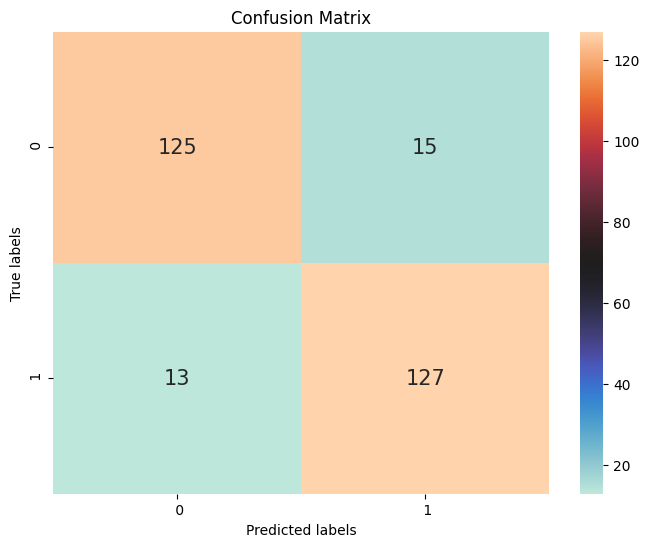

In [59]:
classes = [' 0', ' 1']

# Assuming conf_matrix is your confusion matrix
# Assuming classes is a list of class labels

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='icefire', fmt='g', xticklabels=classes, yticklabels=classes,annot_kws={"size": 15})

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show plot
plt.show()

# get support from tune

In [79]:
def test_episode_support(test_patches_class, test_class_labels, test_K):
    selected_classes = test_class_labels
    support_labels = list(selected_classes)
    support_patches = []

    for x in selected_classes:
        y = test_class_labels.index(x)
        support_imgs = test_patches_class[y][:test_K,]
        support_patches.extend(support_imgs)

    support_patches = torch.reshape(torch.cat(support_patches), (len(support_patches), 1000))
    support_patches = support_patches.unsqueeze(-1)

    return support_patches, torch.tensor(support_labels)

In [80]:
def test_episode_test(test_patches_class, test_class_labels):
    selected_classes = test_class_labels
    all_labels = []
    all_patches = []

    for x in selected_classes:
        y = test_class_labels.index(x)
        class_imgs = test_patches_class[y]
        all_patches.extend(class_imgs)
        for i in range(class_imgs.shape[0]):
            all_labels.append(x)

    temp1 = list(zip(all_patches, all_labels))
    random.shuffle(temp1)
    all_patches, all_labels = zip(*temp1)
    x = len(all_labels)

    all_patches = torch.reshape(torch.cat(all_patches), (x, 1000))
    all_patches = all_patches.unsqueeze(-1)

    return all_patches, torch.tensor(all_labels) , x


In [82]:
ProtoModel.eval()

all_predictions = []
all_labels = []

for epoch in range(1):
    test_loss = 0.0
    test_acc = 0.0
    support_patches, support_labels = test_episode_support(test_patches_class_1, test_class_labels,10)
    query_patches, query_labels, num_queries = test_episode_test(test_patches_class_2, test_class_labels)
    mc_predictions, mean_accuracy, y = test_step(support_patches, query_patches, support_labels, query_labels, 10, 2, num_queries/2)

    mean_predictions =torch.mean(mc_predictions, axis=0)
    class_predictions = torch.argmax(mean_predictions, axis=-1)
    class_labels = torch.argmax(y, axis=-1)

    class_predictions_np = class_predictions.numpy()
    class_labels_np = class_labels.numpy()

    all_predictions.extend(class_predictions_np)
    all_labels.extend(class_labels_np)
    
cm = confusion_matrix(all_labels, all_predictions)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[134  16]
 [ 11 139]]


In [83]:
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       150
           1       0.90      0.93      0.91       150

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300



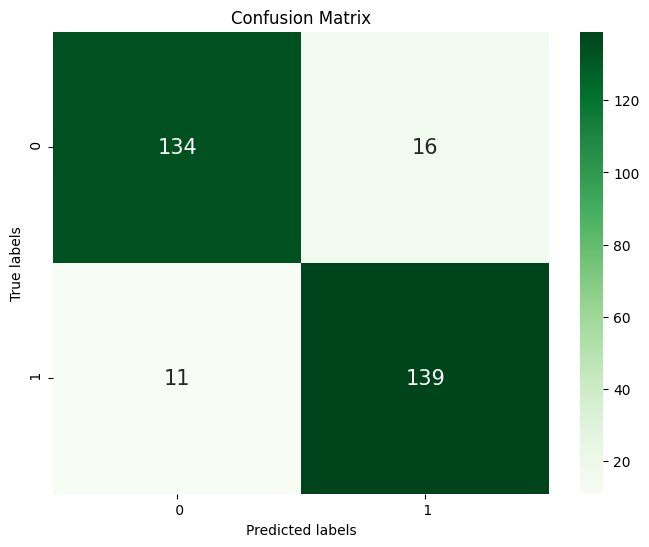

In [84]:
classes = [' 0', ' 1']

# Assuming conf_matrix is your confusion matrix
# Assuming classes is a list of class labels

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', xticklabels=classes, yticklabels=classes,annot_kws={"size": 15})

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show plot
plt.show()

### Create prototype with support data

In [ ]:
support_patches, support_labels = test_episode_support(test_patches_class_1, test_class_labels,10)

In [ ]:
def calc_prototype(support, support_labels, K, C):
    n_class = C
    n_support = K

    tsupport_patches, _ = test_episode_support(support, support_labels, K)
    #tsupport_labels = support_labels.repeat(K)
    cat = tsupport_patches.float()
    z = model_mobilenet(cat)
    z_prototypes = z[:n_class * n_support].view(n_class, n_support, z.shape[-1])
    z_prototypes = torch.mean(z_prototypes, dim=1)
    return z_prototypes


In [ ]:
import json
def save_to_json_new(filename, *arrays):
    json_data = [arr.tolist() for arr in arrays]
    with open(filename, 'w') as json_file:
        json.dump(json_data, json_file)

In [ ]:
tsupport_patches, _ = test_episode_support(test_patches_class_1, test_class_labels, 10)

In [ ]:
prototype_test = calc_prototype(test_patches_class_1, test_class_labels, 10, 2)
prototype_test[1]

In [ ]:
proto0_tensor_reshaped = prototype_test[0].unsqueeze(0)
proto1_tensor_reshaped = prototype_test[1].unsqueeze(0)


d0_squared = calc_euclidean_dists(model_mobilenet(torch.ones(1000)), proto0_tensor_reshaped).item()
d1_squared = calc_euclidean_dists(model_mobilenet(torch.ones(1000)), proto1_tensor_reshaped).item()

In [ ]:
print('d0_squared', d0_squared)
print('d1_squared', d1_squared)

In [ ]:
d0_squared_ = (torch.linalg.vector_norm(model_mobilenet(torch.ones(1000)) - proto0_tensor_reshaped).item()**2)/64
d1_squared_ = (torch.linalg.vector_norm(model_mobilenet(torch.ones(1000)) - proto1_tensor_reshaped).item()**2)/64

In [ ]:
print('d0_squared_:', d0_squared_)
print('d1_squared_:', d1_squared_)

In [ ]:
print("Model Output Shape:", model_mobilenet(torch.ones(1000)).shape)
print("Proto0 Tensor Shape:", proto0_tensor_reshaped.shape)
print("Proto1 Tensor Shape:", proto1_tensor_reshaped.shape)

d0_squared = calc_euclidean_dists(model_mobilenet(torch.ones(1000)), proto0_tensor_reshaped).item()
d1_squared = calc_euclidean_dists(model_mobilenet(torch.ones(1000)), proto1_tensor_reshaped).item()

print("D0 Squared (calc_euclidean_dists):", d0_squared)
print("D1 Squared (calc_euclidean_dists):", d1_squared)

d0_squared_ = (torch.linalg.vector_norm(model_mobilenet(torch.ones(1000)) - proto0_tensor_reshaped).item()**2)/64
d1_squared_ = (torch.linalg.vector_norm(model_mobilenet(torch.ones(1000)) - proto1_tensor_reshaped).item()**2)/64

print("D0 Squared (torch.linalg.vector_norm):", d0_squared_)
print("D1 Squared (torch.linalg.vector_norm):", d1_squared_)

In [ ]:
model_mobilenet.eval()
num_iterations = 10
results_0 = []
results_1 = []

#shot_value = [10]
shot_value = [3, 5, 7, 10, 15, 20, 25 , 30, 40]
iteration_prototypes = []
for value in shot_value:
    prototype = calc_prototype(test_patches_class_1, test_class_labels, value, 2)
    iteration_prototypes.append(prototype)

results_0.append([proto[0].detach().numpy() for proto in iteration_prototypes])
results_1.append([proto[1].detach().numpy() for proto in iteration_prototypes])


del shot_value
del iteration_prototypes

In [ ]:
def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

result_0_flat = [item for sublist in results_0 for item in sublist]
result_0_array = np.array(result_0_flat)
result_0_list = result_0_array.tolist()
converted_result_0 = convert_to_serializable(result_0_list)

result_1_flat = [item for sublist in results_1 for item in sublist]
result_1_array = np.array(result_1_flat)
result_1_list = result_1_array.tolist()
converted_result_1 = convert_to_serializable(result_1_list)


# test prototype

In [ ]:
import json
with open('new_prototype_0.json', 'w') as json_file:
    json.dump(converted_result_0, json_file)

with open('new_prototype_1.json', 'w') as json_file:
    json.dump(converted_result_1, json_file)

In [ ]:
c_test = pd.read_csv('/content/test.csv')

In [ ]:
def read_all_rows_from_csv(file_path):
    df = pd.read_csv(file_path, header=None, skiprows=1)
   # df = df.iloc[:, :-1]
    all_samples = df.values.tolist()
    return all_samples

In [ ]:
json_file_path_0 = '/content/new_prototype_0.json'
json_file_path_1 = '/content/new_prototype_1.json'

with open(json_file_path_0, 'r') as json_file_0:
    proto0 = json.load(json_file_0)

with open(json_file_path_1, 'r') as json_file_1:
    proto1 = json.load(json_file_1)

In [ ]:
csv_file_path = "/content/test.csv"
all_samples = read_all_rows_from_csv(csv_file_path)

model_mobilenet.eval()

sample_size = 1

all_results = []

for input_sample in all_samples:
    tests = []

    for sample_index in range(sample_size):

        proto0_tensor = torch.tensor(proto0[sample_index])
        proto1_tensor = torch.tensor(proto1[sample_index])
        proto0_tensor_reshaped = proto0_tensor.unsqueeze(0)
        proto1_tensor_reshaped = proto1_tensor.unsqueeze(0)

        t_input = torch.tensor([float(value) for value in input_sample], dtype=torch.float32)
        t_input = t_input.detach()
        #print('t_input_shape',t_input.shape)

        # d0 = torch.linalg.norm(model_mobilenet(t_input) - proto0_tensor).item()
        # d1 = torch.linalg.norm(model_mobilenet(t_input) - proto1_tensor).item()

        d0_squared = calc_euclidean_dists(model_mobilenet(t_input), proto0_tensor_reshaped).item()
        d1_squared = calc_euclidean_dists(model_mobilenet(t_input), proto1_tensor_reshaped).item()
        d0 = d0_squared
        d1 = d1_squared
        # print('d0:',d0)
        # print('d1:',d1)
        # print('*****************')

        if d0 < d1:
            tests.append(0)
        elif d1 <= d0:
            tests.append(1)

    majority_vote = 1 if sum(tests) > (sample_size/2) else 0
    sample_results =  tests+   [majority_vote]
    all_results.append(sample_results)